# Figure: Example univariate fit

This figure demonstrates how intrinsic dynamics distort receptive field estimates for a simple univariate case with white-noise stimuli. Requires `batch/univariate.sh` to have been run.

In [1]:
from __future__ import print_function, division
import sys
import imp
import os
import numpy as np
from munch import Munch
from dstrf import spikes, strf, filters
from corner import corner

# plotting packages
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt # plotting functions
import seaborn as sns           # data visualization package
sns.set_style("ticks")
sns.set_context("paper", font_scale=0.7)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['lines.linewidth'] = 0.5
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['xtick.major.size'] = 1.5
mpl.rcParams['ytick.major.size'] = 1.5
#print(mpl.rcParams.keys())
outdir = os.path.join("..", "figures")
est_clr = ["goldenrod", "darkcyan"]
names = ["tonic", "phasic"]
figsize = (1.5, 1.7)

In [16]:
base_dir = "../results/20200622_univariate"

with open("../config/univariate_dynamical.yml", "rt") as fp:
    cf = Munch.fromYAML(fp)

### A: example stimulus, PSTH, and raster plots

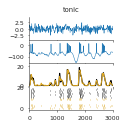

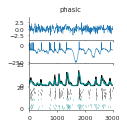

In [17]:
for row, name in enumerate(names):
    data = np.load(os.path.join(base_dir, "univariate_{}_predict.npz".format(name)))
    V = data["V"]
    stim = data["stim"].squeeze()
    tspk = data["spike_v"]
    pspk = data["pspike_v"]
    ntrials = min(tspk.shape[1], 10)
    fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=figsize)
    t_stim = np.linspace(0, data["duration"], stim.size) - 1000
    t_resp = np.linspace(0, data["duration"], V.size) - 1000

    upsample = int(cf.data.dt / cf.model.dt)
    test_psth = spikes.psth(tspk, upsample, 1)
    pred_psth = spikes.psth(pspk, upsample, 1)

    axes[0].plot(t_stim, stim)
    # axes 1: example voltage response
    axes[1].plot(t_resp, V)
    # axes 2: psth
    axes[2].plot(t_stim, test_psth, linewidth=1, color='k', label="data")
    axes[2].plot(t_stim, pred_psth, linewidth=1, color=est_clr[row], label="pred")
    # axes 3: rasters
    for i in range(ntrials):
        spk_t = np.nonzero(tspk[:, i])[0] * cf.model.dt - 1000
        axes[3].vlines(spk_t, i - 0.4 + ntrials, i + 0.4 + ntrials)
    for i in range(ntrials):
        spk_t = np.nonzero(pspk[:, i])[0] * cf.model.dt - 1000
        axes[3].vlines(spk_t, i - 0.4, i + 0.4, color=est_clr[row])

    axes[3].set_xlim(-10, 3000);
    axes[0].set_title(name)
    plt.subplots_adjust(hspace=0.01);
    sns.despine()

    plt.savefig(os.path.join(outdir, "univariate_{}_example.pdf".format(name)))

### B: Plot RF and adaptation kernel for all three models

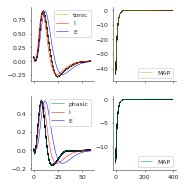

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex='col', figsize=(2.6, 3.0))

ntau = cf.model.filter.len
ncos = cf.model.filter.ncos
kcosbas = strf.cosbasis(ntau, ncos)
k1, kt = filters.gammadiff(**cf.data.filter)
# expected kernel due to the filtering properties of the membrane
km, kmt = filters.exponential(46, 1.0, ntau * cf.data.dt, cf.data.dt)
kconv = np.convolve(km, k1.squeeze(), mode="full")[:-km.size:-1]

for row, name in enumerate(names):
    data = np.load(os.path.join(base_dir, "univariate_{}_samples.npz".format(name)))
    pos = data["samples"]
    prob = data["prob"]
    theta = np.median(pos, 0)

    minprob = np.percentile(prob, 5)

    for i in range(prob.size):
        if prob[i] <= minprob: continue
        k = strf.from_basis(pos[i,3:], kcosbas)[::-1]
        axes[row, 0].plot(k, 'k', alpha=0.01)

    kmap = strf.from_basis(theta[3:], kcosbas)[::-1]
    axes[row, 0].plot(kmap, color=est_clr[row], label=name)
    axes[row, 0].plot(k1.squeeze()[::-1] * kmap.max() / k1.max(), 'r', label="I")
    axes[row, 0].plot(kconv * kmap.max() / kconv.max(), 'b', label="E")

    axes[row, 0].legend()

    # posterior distribution of post-spike kernels
    t = np.arange(0, 400)
    for i in range(prob.size):
        if prob[i] <= minprob: continue
        axes[row, 1].plot(t, 
                 - pos[i,1] * np.exp(-t / cf.model.ataus[0]) - pos[i,2] * np.exp(-t / cf.model.ataus[1]),
                 'k', alpha=0.01)
    axes[row, 1].plot(t, - theta[1] * np.exp(-t / cf.model.ataus[0]) - theta[2] * np.exp(-t / cf.model.ataus[1]), 
                      color=est_clr[row], label="MAP")
    axes[row, 1].legend()
    
sns.despine()
# for ax in axes.flat:
#     ax.tick_params(length=1)
plt.subplots_adjust(wspace=0.3);
plt.savefig(os.path.join(outdir, "univariate_rfs.pdf"))

### C: corner plots

Doesn't appear possible to overlay the plots directly, so plot each separately and then recombine in illustrator.

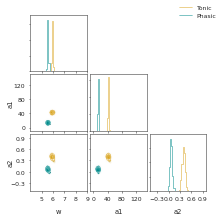

In [19]:
matlabs = ['w','a1','a2']
ranges = [(4, 9), (-10, 150), (-0.5,1)]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(3, 3))
for row, name in enumerate(names):
    data = np.load(os.path.join(base_dir, "univariate_{}_samples.npz".format(name)))
    c = corner(data["samples"][:, :3],
               fig=fig,
               color=est_clr[row],
               range=ranges,
               bins=50, smooth=1,smooth1d=0,
               labels=matlabs)

for ax in axes.flat:
    ax.tick_params(labelrotation=0)
fig.legend(("Tonic", "Phasic"), framealpha=0, loc="upper right")
#plt.savefig(os.path.join(outdir, "univariate_corner.pdf"))